# Cats and Dogs: Aumentando os dados sinteticamente

A técnica de *data augmentation* aumenta o número de exemplos para treinar a rede a partir
de transformações que mantenham as mesmas características da entrada. É uma técnica muito
utilizada e muito efetiva, que previne o *overfitting* da rede.

Neste experimento, o *data augmentation* é realizado pelo *loader* que aplica um conjunto
de transformações geométricas de forma aleatória, fazendo com a mesma imagem nunca seja
apresentada duas vezes para a rede.

Neste notebook utilizam-se uma rede convolucional com max-pooling e uma rede densa no final.

## Importação das bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.optim.lr_scheduler
import torchvision

from lib import pytorch_trainer as ptt
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Dataset

O dataset foi obtido de uma competição do Kaggle, https://www.kaggle.com/c/dogs-vs-cats/data.
Utilizaremos neste exemplo as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    /data/datasets/catsdogs_fewsamples/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

In [2]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, transform=None):
        self.train = train
        self.transform = transform
        if self.train:
            self.dirpath = os.path.join(rootdir, 'train')
        else:
            self.dirpath = os.path.join(rootdir, 'validation')
        print(self.dirpath)
        self.l_filepaths = [fp for fp in sorted(glob.glob(os.path.join(self.dirpath, '**'), recursive=True))
                          if fp[-4:].lower() == '.jpg']
    def __len__(self):
        return len(self.l_filepaths)
    def __getitem__(self, index):
        fp = self.l_filepaths[index]
        out = int(os.path.basename(fp)[:3].lower() == 'dog')
        inp = PIL.Image.open(fp)
        if self.transform is not None:
            inp = self.transform(inp)
        return inp, out

## Data augmentation

In [4]:
rootdir = '/data/datasets/catsdogs_fewsamples'
size_large = (160, 160)
size_final = (150, 150)
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Resize(size=size_large),
                                                    torchvision.transforms.RandomCrop(size=size_final),
                                                    torchvision.transforms.RandomHorizontalFlip(),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Resize(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True,  transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


## Visualizando 5 gatos e 5 cachorros (transformados)

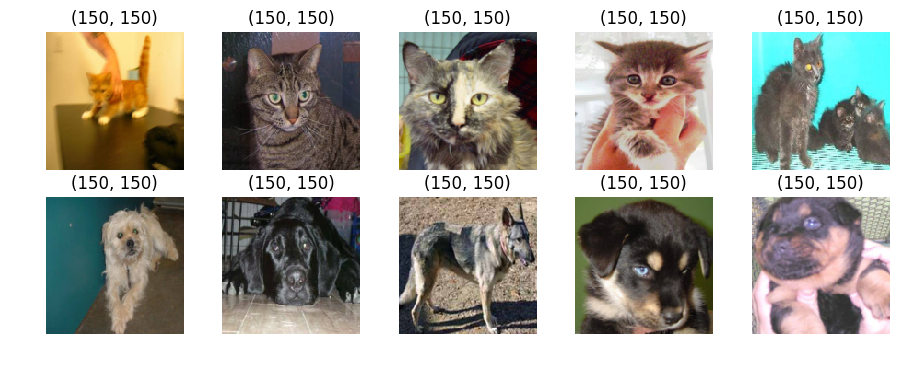

In [5]:
l_imgs = list()
toPIL = torchvision.transforms.ToPILImage()
for idx in list(range(5)) + list(range(-5, 0)): # 5 primeiros e 5 últimos
    l_imgs.append(toPIL(dataset_train[idx][0]))

fig = plt.figure(figsize=(11, 4), dpi=100)
for idx, img in enumerate(l_imgs):
    ax = fig.add_subplot(2, 5, 1 + idx)
    ax.imshow(img)
    ax.set_title('{}'.format(img.size))
    ax.axis('off')
plt.show()

In [6]:
batch_size = 200

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

## Definição da rede

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.relu3 = nn.ReLU()
        self.maxp3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.dens1 = nn.Linear(in_features=64*17*17, out_features=64)
        self.relu4 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)
        self.dens2 = nn.Linear(in_features=64, out_features=2)

    def forward(self, x):        # input:  amostras x  3 x 150 x 150
        x = self.conv1(x)        # output: amostras x 32 x 148 x 148
        x = self.relu1(x)
        x = self.maxp1(x)        # output: amostras x 32 x  74 x  74

        x = self.conv2(x)        # output: amostras x 32 x  72 x  72
        x = self.relu2(x)
        x = self.maxp2(x)        # output: amostras x 32 x  36 x  36

        x = self.conv3(x)        # output: amostras x 64 x  34 x  34
        x = self.relu3(x)
        x = self.maxp3(x)        # output: amostras x 64 x  17 x  17

        x = x.view(-1, 64*17*17) # output: amostras x (64 * 17 * 17)
        x = self.dens1(x)        # output: amostras x 64
        x = self.relu4(x)
        x = self.drop1(x)
        x = self.dens2(x)        # output: amostras x 2

        return x.view(-1, 2)     # output: amostras x 1 x 2

## Instanciando o modelo que usará aumento sintético de dados

In [8]:
model_augm = MyModel()
if use_gpu:
    model_augm = model_augm.cuda()

## Treinamento

In [9]:
n_epochs = 100
optm = torch.optim.Adam(params=model_augm.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/data_augmentation_catsdogs', reset=True, verbose=1)

trainer_augm = ptt.DeepNetTrainer(model         = model_augm,
                                  criterion     = nn.CrossEntropyLoss(),
                                  optimizer     = optm,
                                  lr_scheduler  = schd,
                                  callbacks = [ptt.AccuracyMetric(), 
                                               ptt.PrintCallback(),
                                               cb_chkpt])

In [10]:
train = False
if train:
    trainer_augm.fit_loader(n_epochs, loader_train, valid_data=loader_valid)
else:
    trainer_augm.load_state('/data/models/data_augmentation_catsdogs')

Resultado do treinamento na GPU:

        Start training for 100 epochs
          1:   7.6s   T: 0.69286 0.50950   V: 0.69177 0.50000 best
          2:   7.1s   T: 0.69277 0.50000   V: 0.69057 0.59750 best
          3:   7.6s   T: 0.69052 0.53550   V: 0.68829 0.56750 best
          4:   7.2s   T: 0.68749 0.57400   V: 0.68563 0.60125 best
          5:   7.1s   T: 0.68534 0.54500   V: 0.68163 0.58750 best
          6:   7.3s   T: 0.68278 0.58250   V: 0.67728 0.59250 best
          7:   7.2s   T: 0.67521 0.59800   V: 0.67200 0.63500 best
          8:   7.2s   T: 0.67318 0.60500   V: 0.66571 0.61375 best
          9:   7.2s   T: 0.66786 0.59250   V: 0.66955 0.59500 
         10:   7.2s   T: 0.66811 0.60700   V: 0.65897 0.61625 best
         11:   7.5s   T: 0.65873 0.62350   V: 0.65242 0.65875 best


         94:   7.1s   T: 0.55252 0.73100   V: 0.55918 0.72625 
         95:   7.2s   T: 0.54832 0.72800   V: 0.55784 0.72875 best
         96:   7.2s   T: 0.54877 0.72750   V: 0.55822 0.72625 
         97:   7.2s   T: 0.55625 0.73100   V: 0.55774 0.72875 best
         98:   7.2s   T: 0.54860 0.72650   V: 0.55766 0.73000 best
         99:   7.2s   T: 0.55174 0.72950   V: 0.55787 0.72750 
        100:   7.2s   T: 0.55319 0.73400   V: 0.55749 0.73000 best
        Stop training at epoch: 100/100
        Best model was saved at epoch 100 with loss 0.55749: 
            ../../models/data_augmentation_catsdogs

In [11]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    idx = min(idx, len(trainer.metrics['valid']['acc']) - 1)
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

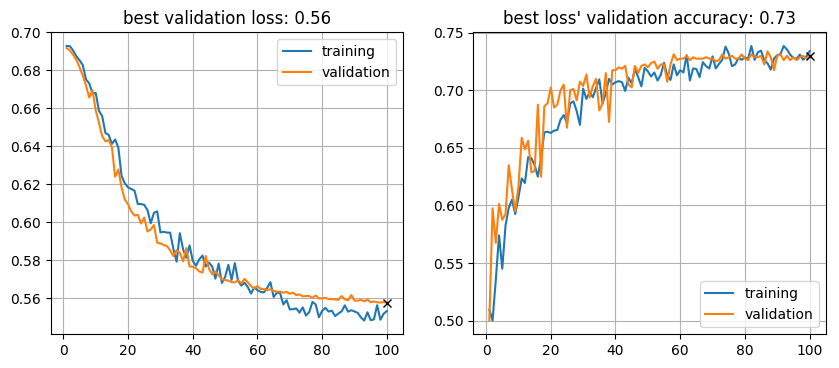

In [12]:
show_history(trainer_augm)

## Treinamento sem aumento de dados

In [14]:
transform_noaug = torchvision.transforms.Compose(
            [torchvision.transforms.Resize(size=size_final),
             torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True,  transform=transform_noaug)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transform_noaug)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

model_noaugm = MyModel()
if torch.cuda.is_available():
    model_noaugm = model_noaugm.cuda()

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


In [15]:
optm = torch.optim.Adam(params=model_noaugm.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/data_no_augmentation_catsdogs', reset=True, verbose=1)

trainer_noaugm = ptt.DeepNetTrainer(model         = model_noaugm,
                                    criterion     = nn.CrossEntropyLoss(),
                                    optimizer     = optm,
                                    lr_scheduler  = schd,
                                    callbacks     = [ptt.AccuracyMetric(), 
                                                     ptt.PrintCallback(),
                                                     cb_chkpt])

In [16]:
if False:
    trainer_noaugm.fit_loader(n_epochs, loader_train, loader_valid)
else:
    trainer_noaugm.load_state('/data/models/data_no_augmentation_catsdogs')

Resultado do treinamento na GPU:

        Start training for 100 epochs
          1:   7.2s   T: 0.69457 0.50400   V: 0.69172 0.58125 best
          2:   7.1s   T: 0.69313 0.50650   V: 0.69133 0.57375 best
          3:   7.1s   T: 0.69144 0.53650   V: 0.69043 0.56375 best
          4:   7.1s   T: 0.68987 0.52550   V: 0.68905 0.54250 best
          5:   7.1s   T: 0.68888 0.52400   V: 0.68768 0.64000 best
          6:   7.1s   T: 0.68785 0.56750   V: 0.68538 0.61000 best
          7:   7.1s   T: 0.68528 0.57800   V: 0.68379 0.64875 best
          8:   7.1s   T: 0.68233 0.58950   V: 0.68008 0.57500 best
          9:   7.1s   T: 0.67716 0.58300   V: 0.67565 0.64000 best
         10:   7.1s   T: 0.66904 0.62850   V: 0.67315 0.55875 best


         94:   7.1s   T: 0.54747 0.74700   V: 0.58627 0.70000 
         95:   7.1s   T: 0.53790 0.74550   V: 0.58543 0.70500 best
         96:   7.1s   T: 0.54506 0.73900   V: 0.58591 0.70000 
         97:   7.1s   T: 0.54669 0.73000   V: 0.58573 0.70375 
         98:   7.1s   T: 0.54456 0.73750   V: 0.58575 0.70375 
         99:   7.1s   T: 0.53789 0.74050   V: 0.58525 0.70250 best
        100:   7.1s   T: 0.54255 0.73900   V: 0.58539 0.70250 
        Stop training at epoch: 100/100
        Best model was saved at epoch 99 with loss 0.58525: ../../models/data_no_augmentation_catsdogs

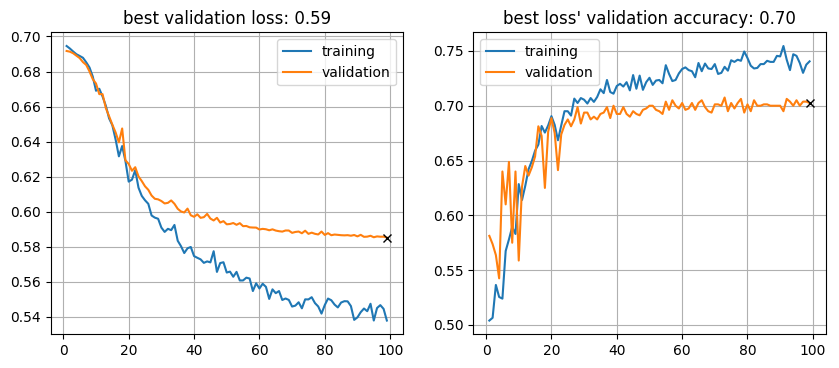

In [17]:
show_history(trainer_noaugm)

## Exercícios

1. Na célula "Visualizando 5 gatos e 5 cachorros", crie uma nova célula para mostrar os
   mesmos 5 gatos e 5 cachorros e observe as transformações aleatórias que são feitas
2. Visualize 5 gatos e 5 cachorros do conjunto de validação e observe que eles não são
   transformados

## Aprendizados com este notebook

